In [150]:
import numpy as np , pandas as pd
import torch
import torch.nn as nn
import einops

In [3]:
df = pd.read_csv("../../datasets/income/adult.csv")

In [4]:
df.insert(0, "start","<start>")
df["end"] = "<end>"

In [5]:
df

,start,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,end
0,<start>,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K,<end>
1,<start>,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,<end>
2,<start>,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K,<end>
3,<start>,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,<end>
4,<start>,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,<end>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,<start>,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K,<end>
32557,<start>,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,<end>
32558,<start>,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,<end>
32559,<start>,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,<end>


In [6]:
df.rename(columns={"marital.status":"marital_status",
                   "education.num" : "education_num",
                   "capital.gain": "capital_gain",
                   "capital.loss":"capital_loss",
                   "hours.per.week":"hours_per_week",
                   "native.country":"native_country"},inplace=True)

In [7]:
# # so the script looks like: 
import pandas as pd
import pickle
from utils.column_code import ColumnTokenizer, FloatTokenizer, CategoricalTokenizer
from utils.tabular_tokenizer import TabularTokenizer

# Constants
START = "<start>"
ENDOFTEXT = '<end>'
DELIMITER = '|'
VOCABULARY_PATH = 'income_coder.pickle'
FLOAT_COLS = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
EXCLUDED_COLS = []

# Sample DataFrame (replace with your actual data)
# df = pd.read_csv("../../datasets/income/adult.csv")  # Assuming the dataset path is correct

# Fill missing values
df = df.fillna('?')

# Initialize ColumnTokenizer
column_codes = ColumnTokenizer()
beg = 0
cc = None
columns = [col for col in df.columns if col not in EXCLUDED_COLS]

# Register columns
for column in columns:
    start_id = beg if cc is None else cc.end_id
    if column in FLOAT_COLS:
        cc = FloatTokenizer(column, df[[column]], start_id, transform="log")
    else:
        cc = CategoricalTokenizer(column, df[column], start_id)
    column_codes.register(column, cc)

# Save the encoder and decoder
with open(VOCABULARY_PATH, 'wb') as handle:
    pickle.dump(column_codes, handle)

# Load the tokenizer
tokenizer = TabularTokenizer(VOCABULARY_PATH, special_tokens=['\n', ENDOFTEXT], delimiter=DELIMITER)

# Encode the DataFrame
encoded_docs = []
for _, row in df.iterrows():
    encoded_row = []
    for col in columns:
        encoded_value = column_codes.encode(col, str(row[col]))
        encoded_row.extend(encoded_value)
    encoded_docs.append(encoded_row)

# Decode a sample encoded row
sample_encoded_row = encoded_docs[0]
decoded_row = []
for col, size in zip(columns, column_codes.sizes):
    token_ids = sample_encoded_row[:size]
    decoded_value = column_codes.decode(col, token_ids)
    decoded_row.append(decoded_value)
    sample_encoded_row = sample_encoded_row[size:]

# Display the encoded documents and decoded row
print(f"Encoded Documents (first 3): {encoded_docs[:3]}")  # Show the first 3 encoded documents
print(f"Decoded Row: {decoded_row}")  # Show the decoded values of the first encoded row


Encoded Documents (first 3): [[0, 25, 14, 1, 26, 35, 21683, 21716, 21707, 21705, 21717, 21724, 21739, 21745, 21750, 21830, 21822, 21812, 21802, 21792, 21782, 21772, 21762, 21752, 21906, 21895, 21889, 21881, 21867, 21855, 21851, 21832, 21930, 21923, 21915, 21932, 21974, 21976], [0, 25, 12, 9, 27, 36, 21683, 21716, 21707, 21705, 21717, 21725, 21739, 21745, 21750, 21830, 21822, 21812, 21802, 21792, 21782, 21772, 21762, 21752, 21906, 21895, 21889, 21881, 21867, 21855, 21851, 21832, 21929, 21925, 21916, 21932, 21974, 21976], [0, 24, 20, 2, 26, 37, 21684, 21716, 21708, 21699, 21717, 21724, 21740, 21746, 21750, 21830, 21822, 21812, 21802, 21792, 21782, 21772, 21762, 21752, 21906, 21895, 21889, 21881, 21867, 21855, 21851, 21832, 21930, 21923, 21915, 21932, 21974, 21976]]
Decoded Row: ['<start>', '89.69979', '?', '77053', 'HS-grad', '8.93521', 'Widowed', '?', 'Not-in-family', 'White', 'Female', '0.00000', '4355.99989', '39.64639', 'United-States', '<=50K', '<end>']


In [15]:
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
class TokenDataset(Dataset):
    def __init__(self, encoded_docs, seq_length):
        self.encoded_docs = encoded_docs
        self.seq_length = seq_length
        self.context_window = len(encoded_docs[0])
        self.start_seed = [0] * (self.context_window - 1)

        # this is very expensive aviod reinit
        def compile_dataset():
            X,y  = [],[]
            for row in tqdm(encoded_docs):
                context = self.start_seed # take account of start token
                # predict start 
                for token in row:
                    print(context)
                    X.append(context)
                    y.append(token)
                    context = context[1:] + [token]

            X = torch.tensor(X)
            y = torch.tensor(y)
            return X,y
        
        self.X , self.y = compile_dataset()
                

    def __len__(self):
        return len(self.encoded_docs)
    

    def __getitem__(self, idx):
        inputs = self.X[idx]
        targets = self.y[idx]
        return torch.tensor(inputs), torch.tensor(targets)

In [16]:
len(encoded_docs[0])

38

In [17]:
dataset = TokenDataset(encoded_docs, seq_length = len(encoded_docs[0]))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

  2%|▏         | 704/32561 [00:00<00:04, 7035.49it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

  6%|▋         | 2107/32561 [00:00<00:05, 5142.32it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

 11%|█         | 3649/32561 [00:00<00:04, 6063.37it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_

In [18]:
for X,y in dataloader:
    print(X.shape, y.shape)
    break

torch.Size([32, 37]) torch.Size([32])


/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_63091/840449733.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)


In [100]:
vocab_length = tokenizer.__len__()

In [110]:
context_window = X.shape[1]
context_window

37

In [133]:
# candidates for n_heads 😒
for i in range(1,int(vocab_length//3)):
    if vocab_length % i == 0:
        print(i)

1
31
709


In [166]:
config = {
    "vocab_length" : vocab_length,
    "n_embed" : 992, # should be divisible by n_heads
    "n_heads" : 31, # needs to be divisible by vocab_len
    "context_window":context_window,
    "transformer_blocks":2,
    "batch_size":32,
    "random_seed":123,
}

# dump this to json later
config = pd.Series(config)

In [194]:
class SingleHead(nn.Module):
    """
    Implements a single head of attention (unmasked)
    """

    def __init__(self,R,head_size,manual_seed=123):
        super().__init__()
        # single head
        self.head_size = head_size
        self.scale = 1/ torch.sqrt(torch.tensor(self.head_size))
        self.R = torch.tensor(R)
        self.Q = nn.Parameter( torch.randn(self.R,head_size))
        self.K = nn.Parameter( torch.randn(self.R,head_size))
        self.V = nn.Parameter( torch.randn(self.R,head_size))

    def forward(self,x):
        q = x @ self.Q # (B,T,R) * (R,h) => (B,T,R) x (B,R,h) => (B,T,h) 
        k = x @ self.K
        v = x @ self.V

        comm = q @ einops.rearrange(k,"B T h -> B h T") # (B,T,h) @ (B,h,T) => B,T,T @ each tokens interaction with each token would be T,T
        att1 = nn.functional.softmax(comm * self.scale,dim=2) # along tokens head
        attention = att1 @ v # B,T,T @ B,T,h => B,T,h
        return attention


In [195]:
class Multihead(nn.Module):
    def __init__(self,R,n_heads,seed=123):
        self.R = R
        assert R % n_heads == 0 , "n_heads is not divisible by R"
        self.head_size = self.R // n_heads
        self.n_heads = n_heads

        super().__init__()
        self.multiheads = nn.ModuleList(
            [SingleHead(self.R,self.head_size)  for _ in range(self.n_heads)]
        )

    def forward(self,x):
        return torch.cat([head(x) for head in self.multiheads],dim=2)

In [220]:
class IncomeTransformer(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.context_window = config.context_window
        self.n_embed = config.n_embed
        self.n_heads = config.n_heads
        self.n_vocab = config.vocab_length
        self.transformer_blocks = config.transformer_blocks

        #==== Token (C) and positional Embedding (pe)
        self.C = nn.Embedding(self.n_vocab,self.n_embed) # token embedding
        self.pe = nn.Parameter(torch.randn(1,self.n_embed)) # position embedding
        
        #===== Transformer Blocks
        self.multi_heads = Multihead(R=self.n_embed, n_heads=self.n_heads)
        self.layer_norm = nn.LayerNorm(self.n_embed) #at the end of the transformer block
        
        #==== MLP Head
        self.mlp_head0 = nn.Linear(self.context_window * self.n_embed , self.n_embed)
        self.mlp_head1 = nn.Linear(self.n_embed,self.n_vocab) # logits
        
        
        
    def forward(self,x):
       emb = self.C(x) # token emb
       emb += self.pe # add pos emb
       
       # write a loop later
       attn = self.multi_heads(emb)
       normed = self.layer_norm(attn + emb)# layer norm and skip connection
       
       # flatten
       normed = einops.rearrange(normed,"b t e -> b (t e)")
       x = self.mlp_head0(normed)
       logits = self.mlp_head1(x) # logits
       
       return logits

    def calculate_loss(self,x,y):
        logits = self(x)
        return logits , nn.functional.cross_entropy(logits,y)

    def generate(self,seed = [0] * 37,verbose=False):
        generation = list()
        i = 0
        while True:
            if i > 50:
                # clearly untrained
                break
            if verbose:
                print(seed)
            logits = self(torch.tensor(seed).view(1,-1))
            probs = nn.functional.softmax(logits,dim=1)
            prediction = torch.multinomial(probs,num_samples=1)
            generation.append(prediction.item())
            if prediction.item() == 21976:
                break
            seed = seed[1:] + [prediction.item()]
            if verbose:
                print(prediction.item())
            i = i+1
        return generation
       
       
        
model = IncomeTransformer(config)

In [221]:
out = model(X)
out.shape

torch.Size([32, 21979])

In [222]:
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [223]:
track_loss = list()

In [227]:
# just 1 epoch..
i = 0
for Xb,yb in tqdm(dataloader):
    # forward pass
    _,loss = model.calculate_loss(Xb,yb)

    # flush the gradients 
    optimizer.zero_grad(set_to_none=True)

    # backprop
    loss.backward()

    # learning step
    optimizer.step()

    # for plotting
    track_loss.append(loss.item())


  0%|          | 0/1018 [00:00<?, ?it/s]/var/folders/f0/_f_gy0t91jqchv14f0hcl_gh0000gn/T/ipykernel_63091/840449733.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)
100%|██████████| 1018/1018 [08:10<00:00,  2.08it/s] 


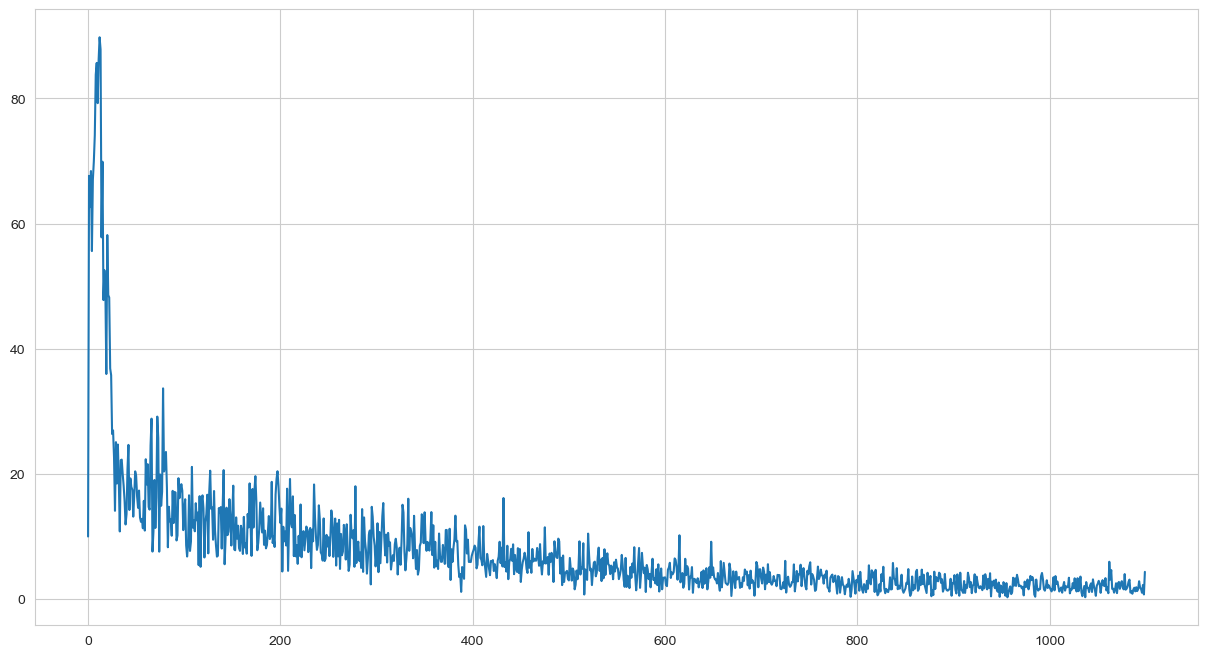

In [228]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(track_loss)
plt.show()

In [217]:
#expected loss
np.log(1/config.vocab_length)

-9.997842731017274

In [233]:
loss

tensor(4.3639, grad_fn=<NllLossBackward0>)

In [230]:
model.generate()

[24,
 15,
 1,
 27,
 175,
 21695,
 21715,
 21706,
 21705,
 21718,
 21725,
 21740,
 21745,
 21750,
 21830,
 21822,
 21812,
 21802,
 21792,
 21782,
 21772,
 21762,
 21752,
 21905,
 21900,
 21886,
 21878,
 21864,
 21858,
 21850,
 21834,
 21931,
 21891,
 21907,
 21932,
 21975,
 21976]

In [231]:
len(model.generate())

37